In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as ss
import gc
import copy
from PIL import Image
from matplotlib.pyplot import imshow
from sklearn.base import BaseEstimator, ClassifierMixin
from os import listdir, mkdir
from os.path import isfile, join
import math
from datetime import datetime
import time
from skimage.transform import radon
from skimage import color, data, restoration
from scipy import ndimage
from IPython.display import clear_output
from method import momentum_method

ModuleNotFoundError: No module named 'method'

In [1]:
def rgb2gray(rgb):
    '''
    Turns image with 4 color channels into double-dimensional
    '''
    if (len(rgb.shape) == 3):
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    else:
        gray = rgb
    return gray

def inverse_colors(img):
    t = np.zeros(img.shape)
    max_value = np.max(img)
    min_value = np.min(img)
    s = np.shape(t)
    print(s, max_value, min_value)
    for y in range(s[0]):
        for x in range(s[1]):
            t[y,x] = (max_value + min_value - img[y, x])
    return t
    
def S(image, axis='x', offset=1, boundary='symm'):
    '''
    Offset operator of image along given axis
    '''
    if offset == 0:
        return image
    width = image.shape[1] 
    height = image.shape[0] 
    out_image = np.ndarray([height, width], dtype=float)
    if axis == 'x':
        if offset > 0:
            for i in range(offset):
                out_image[:, offset - i] = image[:, i]
            for i in range(offset, width):
                out_image[:, i] = image[:, i- offset]
        else:
            offset = -offset
            for i in range(offset):
                out_image[:, width - 1 - offset + i] = image[:, width - 1 - i]
            for i in range(width - 1 - offset):
                out_image[:, i] = image[:, i + offset]
    if axis == 'y':
        if offset > 0:
            for i in range(offset):
                out_image[offset - i] = image[i]
            for i in range(offset, height):
                out_image[i] = image[i - offset]
        else:
            offset = -offset
            for i in range(offset):
                out_image[height - 1 - offset + i] = image[height - 1 - i]
            for i in range(height - 1 - offset):
                out_image[i] = image[i + offset]
                
    return out_image

In [39]:
class FunctionalMinimisation:
    '''
    Z_alpha = arg min(||Az - u||_1 + TV[z])
    
    grad(Z_alpha) = 2A^T(Az-u) + mult * D(TV[z])
    '''
    def __init__(self, image, kernel, beta_list):
        self._init_image = copy.deepcopy(image)
        self._cur_image = FixImage(copy.deepcopy(image))
        self.kernel = copy.deepcopy(kernel)
        
        self._left_grad = 0
        self._reg_grad = 0
        
        self._betas = beta_list
        self._mu = 0.85
        self._v = 0
        return
        
    def _sign_map(self, image, x_offset, y_offset):
        '''
        For derivative of Total Variation
        '''
        return np.sign(S(S(image, axis='x', offset=x_offset), axis='y', offset=y_offset) - image)

    def _offset_image(self, image, x_offset, y_offset):
        '''
        Returns image, shifted in x_offset pixels along X and in y_offset pixels along Y
        '''
        return S(S(image, axis='x', offset = x_offset), axis='y', offset = y_offset)
    
    def _count_gradient(self):
        
        Q = [[1, 0], [0, 1], [1, 1], [1, -1]]
    
        reg_grad = 0
        
        for cur_Q in Q:
            a = self._sign_map(self._cur_image + self._mu * self._v, cur_Q[0], cur_Q[1])
#             a = self._sign_map(self._cur_image, cur_Q[0], cur_Q[1])
            reg_grad += (1/math.sqrt(cur_Q[0]**2 + cur_Q[1]**2)) *\
                (self._offset_image(a, - cur_Q[0], - cur_Q[1]) - a)

        self._reg_grad = reg_grad
        self._left_grad = 2 * ss.convolve2d(ss.convolve2d(
                                                    self._cur_image + self._mu * self._v,
                                                    self.kernel,
                                                    mode='same',
                                                    boundary='symm')\
                                                - self._init_image,\
                                                self.kernel,
                                                mode='same',
                                                boundary='symm')
#         self._left_grad = ss.convolve2d(ss.convolve2d(self._cur_image,
#                                                       self.kernel,
#                                                       mode='same',
#                                                       boundary='symm')\
#                                                 - self._init_image,\
#                                                 self.kernel,
#                                                 mode='same',
#                                                 boundary='symm')
        return
        
    def _count_v(self, beta = 1):
        '''
        Nesterov accelerated gradient(II variant in presentation)
        g_k = grad(f(z_k + mu * v_k))
        v_(k+1) = mu * v_k - beta_k * g_k
        z_(k+1) = z_k + v_(k+1)
        '''
        mult = 0.5
        reg_mult = 0.001
        self._v = self._mu * self._v - beta * mult * (self._left_grad + reg_mult * self._reg_grad)
        
    def _update_image(self):
        self._cur_image += self._v
#         FixImage(self._cur_image)
        
    def MainProcess(self):
        t = time.time()
        for idx, i in enumerate(self._betas):
            print (idx, "iteration finished: ", time.time() - t)            
            print ("Calculating gradient: ", time.time() - t)            
            self._count_gradient()
            print ("Calculating v: ", time.time() - t)            
            self._count_v(i)
            print ("Update image: ", time.time() - t)            
            self._update_image()

In [3]:
def FixImage(image):
    '''
    Returns image with values in [0, 1] segment
    for normal output with possible negative elements
    '''
    min_value = image.min()
    max_value = image.max()
    if min_value < 0:
        image -= min_value
    return image / (max_value - min_value)
        
def images_out(class_elem):
    '''
    Relatively normal output 
    of _cur_image and _init_image 
    in element of FunctionalMinimisation class
    '''
    plt.figure(figsize=(35,35))
    plt.subplot(1,2,1)
    plt.imshow(FixImage(class_elem._cur_image), cmap='gray')

    plt.subplot(1,2,2)
    plt.imshow(FixImage(class_elem._init_image), cmap='gray')

def save_img(class_elem, p='my_stuff.png', p_b='blurred.png'):
    plt.imsave(p, class_elem._cur_image, cmap='gray')
    plt.imsave(p_b, class_elem._init_image, cmap='gray')

DEBUG = True

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.299 * r + 0.5870 * g + 0.1140 * b
    return gray

def blend_images(orig, four, alpha = 0.8, colH = 10, w=1):
    orig_img = Image.open(orig).convert('RGBA')
    fourier_img = Image.open(four).convert('RGBA')
        
    orig_img = orig_img.resize(((fourier_img.size[0], fourier_img.size[1])), Image.BICUBIC)
    
    img = fourier_img
    A = img.getchannel('A')

    # Convert to HSV and save the V (Lightness) channel
    V = img.convert('RGB').convert('HSV').getchannel('V')

    # Synthesize new Hue and Saturation channels using values from colour picker
    colpickerH, colpickerS = colH, 255
    newH=Image.new('L',img.size,(colpickerH))
    newS=Image.new('L',img.size,(colpickerS))

    # Recombine original V channel plus 2 synthetic ones to a 3 channel HSV image
    HSV = Image.merge('HSV', (newH, newS, V))

    # Add original Alpha layer back in
    R,G,B = HSV.convert('RGB').split()
    RGBA = Image.merge('RGBA',(R,G,B,A))
    
    new_img = Image.blend(orig_img, RGBA, alpha)
    return new_img

def calculate_log(picture,threshold=0.5):
    log = np.log(np.abs(np.fft.fft2(Cepstrum.hamming(picture))))
    fourier_abs = np.abs(log)
    return fourier_abs

def wiener_filter(img, kernel, K=1):
    if np.shape(kernel)[0] == 0:
        return img
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = np.fft.fft2(dummy)
    kernel = np.fft.fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(np.fft.ifft2(dummy))
    return dummy

def get_blur_len(img, angle, weight, w=1):
    rotated_img = ndimage.rotate(img, -angle * 180/math.pi)
    rotated_img[rotated_img < 4/255 * rotated_img.max()] = 0
    r = radon(rotated_img, theta=[90], circle=False)
    r[r > 0.6 * r.max()] = 0
    r *= 1./max(r)
    blur_len = 0
    for i in range(len(r)):
        if (r[i] > 0.7):
            blur_len = len(r) // 2 - 1 - i 
#             if (blur_len > 2 * img.shape[0] // 5):
#                 blur_len = 0
            break
    
    if (DEBUG):
        h = img.shape[0]
        q = h // 2 - 1
        k = -math.tan(angle)
        b = (1 - k) * q
        l = []
        if abs(abs(angle * 180/math.pi) - 90) > 10:
            for old_x in range(q - blur_len, q + blur_len):
                old_y = round(k * old_x+b)
                old_y = int((old_y if old_y >= 0 else 0) if old_y <= h-1 else h-1)
                if (old_y <= 1 or old_y >= h-2 or old_x <= 1 or old_x >= h-2):
                    continue
                for i in range(-w, w+1):
                    for j in range(-w, w+1):
                        x = old_x
                        y = old_y
                        y += i
                        y = (y if y >= 0 else 0) if y <= h-1 else h-1
                        x += j
                        x = (x if x >= 0 else 0) if x <= h-1 else h-1
                        if (y, x) not in l:
                            l.append((y, x))
        else:
            for y in range(q - blur_len, q + blur_len):
                for i in range(-w, w+1):
                    if (y, q + i) not in l:
                        l.append((y, q + i))
        p = np.zeros((h, h))
        for t in l:
            p[t] = weight
    return (int(abs(blur_len)), p)

def find_best_line(template_picture, dif=180):
    h = template_picture.shape[0]
    q = h // 2 - 1
    theta = np.linspace(0., 180, dif, endpoint=False)
    sinogram = radon(template_picture, theta=theta, circle=True)
    max_values = sinogram.max(axis=0)
    if DEBUG:
        tmp.append(sinogram)
    return (max(max_values), theta[np.argmax(max_values)] * math.pi/180 - math.pi/2)

def make_ker(ker_len, ker_angle):
#     h = ker_len * 2
    h = ker_len
    ker_len = ker_len // 2
    ker = np.zeros((h, h), dtype='float')
    
    k = -math.tan(ker_angle)
    b = (1 - k) * ker_len
    if abs(abs(ker_angle * 180/math.pi) - 90) > 10:
        for x in range(h):
            y = round(k * x + b)
            y = int((y if y >= 0 else 0) if y <= h-1 else h-1)
            if (y == 0 or y == h - 1):
                continue
            ker[y, x] = 1
    else:
        for y in range(h):
            ker[y, ker_len] = 1 
    ret_value = ker/ker.sum()
    if np.isnan(np.sum(ret_value)):
        return []
    else:
        return ret_value

def get_common_ker_len_angle(kers):
    max_shape = max([a[0] for a in kers])
    lenghts = [a[0] for a in kers]
    angles =  [a[1] for a in kers]
    
    return (int(np.mean(lenghts)), np.mean(angles))

class Cepstrum:
    def __init__(self, picture, batch_size=64, step=0.25):
        gc.enable()
        self.batch_size = batch_size
        self.step = step
        self.x_batches = int(picture.shape[1] // (batch_size * step) - 1)
        self.y_batches = int(picture.shape[0] // (batch_size * step) - 1)
        self.picture = copy.deepcopy(picture)
        self.squared_image = [0] * self.x_batches * self.y_batches
        plt.imsave('orig_img.png', self.picture, cmap='gray')

    def get_square(self):
        pixel_step = int(self.batch_size * self.step)
        for y in range(self.y_batches):
            for x in range(self.x_batches):
                square = self.picture[y * pixel_step : y * pixel_step + self.batch_size,
                                   x * pixel_step : x * pixel_step + self.batch_size]
                self.squared_image[y * self.x_batches + x] = square
                yield self.swap_quarters(Cepstrum.calculate_cepstrum(square))

    def ft_array(self):
        # CALCULATE CEPSTRUMS
        
        t = time.time()
            
        self.count_ft()
        if (DEBUG):
            print("Counted cepstrums: ", time.time() - t)
        self.count_angles()
        if (DEBUG):
            print("Counted angles: ", time.time() - t)
        self.count_lengths()
        if (DEBUG):
            print("Counted lengths: ", time.time() - t)
        self.make_kernels()
        if (DEBUG):
            print("Counted kernels: ", time.time() - t)
        
        self.weight = self.weight.reshape((self.y_batches, self.x_batches))
        self.weight /= self.weight.max()
        self.angle = self.angle.reshape((self.y_batches, self.x_batches))
        self.blur_len = self.blur_len.reshape((self.y_batches, self.x_batches))
        if (np.max(self.blur_len) == 0) :
            print("Unable to calculate blur lengths")
            return
#         self.kernels = np.reshape(self.kernels, (self.y_batches, self.x_batches, 2)) #here
        self.blur_len_value, self.angle_value = get_common_ker_len_angle(self.kernels)
        self.squared_image = np.reshape(self.squared_image, (self.y_batches, self.x_batches, self.batch_size, self.batch_size))
        # self.restore1() 
#         self.restore() #here
        
    def MainProcess(self):
        self.ft_array()
        try:
            temp2 =[ 0 ] * self.y_squares
            for y in range(self.y_squares):
                temp2[y] = np.hstack(self.restored_image[y, :, :, :])
            self.restored_image_full = np.vstack(temp2)
        except AttributeError as error:
            return
            
    def hamming(picture):
        hm_len = picture.shape[0]
        bw2d = np.outer(ss.hamming(hm_len), np.ones(hm_len))
        bw2d = bw2d * bw2d.T
        return picture * bw2d
    
    def calculate_cepstrum(picture,threshold=0.5):
        log = np.log(1 + np.abs(np.fft.fft2(Cepstrum.hamming(picture))))
        fourier_abs = np.abs(np.fft.ifft2(log))
        fourier_abs[fourier_abs >= threshold * fourier_abs.max()] = 0
        fourier_abs[fourier_abs >= threshold * fourier_abs.max()] = 0
        
        return fourier_abs
    
    def swap_quarters(self, picture):
        out_pict = copy.deepcopy(picture)
        batch_size = picture.shape[0]
        temp_pict = copy.deepcopy(out_pict[: batch_size//2, : batch_size//2])
        out_pict[: batch_size//2, : batch_size//2] = out_pict[batch_size//2 :, batch_size//2 :]
        out_pict[batch_size//2 :, batch_size//2 :] = temp_pict
        temp_pict = copy.deepcopy(out_pict[: batch_size//2, batch_size//2 :])
        out_pict[: batch_size//2, batch_size//2 :] = out_pict[batch_size//2 :, : batch_size//2]
        out_pict[batch_size//2 :, : batch_size//2] = temp_pict[:]
        return out_pict
    
    def restore(self):
        self.cut_image = []
        pixel_step = self.batch_size
        self.y_squares = int(self.picture.shape[0] // self.batch_size)
        self.x_squares = int(self.picture.shape[1] // self.batch_size)
        for y in range(self.y_squares):
            for x in range(self.x_squares):
                square = self.picture[y * pixel_step : y * pixel_step + self.batch_size,
                                   x * pixel_step : x * pixel_step + self.batch_size]
                self.cut_image.append(square)
        self.cut_image = np.reshape(self.cut_image, (self.y_squares, self.x_squares, pixel_step, pixel_step))
        self.restored_image = np.copy(self.cut_image)

        ker_divider = int(1. / self.step)
        self.new_kernels = [[0] * self.x_squares] * self.y_squares
        
        def tf(y, x):
            new_y = int((y if y >= 0 else 0) if y <= self.y_batches - 1 else self.y_batches - 1)
            new_x = int((x if x >= 0 else 0) if x <= self.x_batches - 1 else self.x_batches - 1)
            return (new_y, new_x)
        
        for y_orig in range(self.y_squares):
            for x_orig in range(self.x_squares):
                k_l = []
                for y in range(-ker_divider + 1, ker_divider):
                    for x in range(-ker_divider + 1, ker_divider):
                        k_l.append(self.kernels[tf(y_orig * ker_divider + y, x_orig * ker_divider + x)])
                
                self.new_kernels[y_orig][x_orig] = make_ker(get_common_ker_len_angle(k_l))
                print(y_orig, x_orig)
                self.restored_image[y_orig, x_orig] =\
                    self.restore_function(self.cut_image[y_orig, x_orig], self.new_kernels[y_orig][x_orig])
        return self.restored_image
    
    def restore1(self):
        self.deb_ker = make_common_ker(self.kernels)
        plt.imsave(save_dir + filename[:-4] + '_ker_'+ str(c.batch_size) +'.png', self.deb_ker, cmap='gray')
        self.restored_image_full = self.restore_function(self.picture, self.deb_ker)
    
    def count_ft(self):
        self.cepstrum_picture = np.array(list(self.get_square()))
            
        self.conc_cepstrum_picture = self.cepstrum_picture.reshape((self.y_batches, self.x_batches, self.batch_size, self.batch_size))
        temp  = [ 0 ] * self.y_batches
        for y in range(self.y_batches):
            temp[y] = np.hstack(self.conc_cepstrum_picture[y, :, :, :])
        self.conc_cepstrum_picture = np.vstack(temp)
        plt.imsave('big_img.png', self.conc_cepstrum_picture, cmap='gray')
    
    def count_angles(self):
        self.weight = np.ndarray((self.y_batches * self.x_batches), dtype='float')
        self.angle = np.ndarray((self.y_batches * self.x_batches), dtype='float')
        if (DEBUG):
            self.lines_img = np.copy(self.cepstrum_picture)
        for idx, q in enumerate(self.cepstrum_picture):
            self.weight[idx], self.angle[idx] = find_best_line(q)
                
    def count_lengths(self):
        self.blur_len = np.ndarray((self.y_batches * self.x_batches), dtype='int')
        for idx, q in enumerate(self.cepstrum_picture):
            self.blur_len[idx], self.lines_img[idx] = get_blur_len(q, self.angle[idx], self.weight[idx])
            self.conc_lines_img = self.lines_img.reshape((self.y_batches, self.x_batches, self.batch_size, self.batch_size))
            temp  = [ 0 ] * self.y_batches
            for y in range(self.y_batches):
                temp[y] = np.hstack(self.conc_lines_img[y, :, :, :])
            self.conc_lines_img = np.vstack(temp)
            plt.imsave('lines_img.png', self.conc_lines_img, cmap='gray')
            
    def make_kernels(self):
        self.kernels = [0] * self.y_batches * self.x_batches
        for idx, q in enumerate(self.cepstrum_picture):
            self.kernels[idx] = (self.blur_len[idx], self.angle[idx])
            
    def restore_function(self, img, kernel):
#         img /= img.max()
#         if (np.shape(kernel)[0] == 0):
#             return img
#         self.z_0 = np.zeros(img.shape)
#         return momentum_method(self.z_0, 0.85, kernel, img)
#         return wiener_filter(img, kernel)    
        betas = [0.01/math.sqrt(i) for i in range(1, 60)]
        self.minimis = FunctionalMinimisation(img, kernel, betas)
        self.minimis.MainProcess()
        return self.minimis._cur_image

In [4]:
work_dir = "../pict/"
s = str(datetime.now())
save_dir = '../res/res_' + s[8:10] + '_' + s[5:7] + '/'
print(save_dir)
try:
    # Create target Directory
    mkdir(save_dir)
except FileExistsError:
    o = 5

../res/res_07_03/


FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: '../res/res_07_03/'

In [5]:
# filename = "mb0.jpg"
filename = "low_pig_rotated.jpg"
filename = "cm.png"
filename = "q.jpg"
filename = "lena_ne_enormous.png"
filename = "pl_l.jpg"
# filename = "mb2_low.jpg"
# filename = "mandarin_vert_large.png"

img = rgb2gray(plt.imread(work_dir + filename))

plt.figure(figsize=(10,230))
plt.imshow(img, cmap='gray')

FileNotFoundError: [Errno 2] No such file or directory: '../pict/pl_l.jpg'

In [9]:
tmp = []
c = Cepstrum(img, batch_size=256, step=0.5)

In [10]:
%%time
c.MainProcess()
plt.imsave('big_img.png', c.conc_cepstrum_picture, cmap='gray')

Counted cepstrums:  7.5035881996154785
Counted angles:  123.70216870307922
Counted lengths:  556.0477471351624
Counted kernels:  556.0477471351624
0 iteration finished:  0.0
Calculating gradient:  0.0
Calculating v:  120.52725291252136
Update image:  120.59623146057129
1 iteration finished:  120.60824179649353
Calculating gradient:  120.60824179649353
Calculating v:  243.5294041633606
Update image:  243.61938881874084
2 iteration finished:  243.62638592720032
Calculating gradient:  243.627375125885
Calculating v:  366.9925637245178
Update image:  367.0785357952118
3 iteration finished:  367.08953642845154
Calculating gradient:  367.0915331840515
Calculating v:  490.17209935188293
Update image:  490.265070438385
4 iteration finished:  490.27608036994934
Calculating gradient:  490.27608036994934
Calculating v:  613.3953611850739
Update image:  613.4813365936279
5 iteration finished:  613.4923341274261
Calculating gradient:  613.4933314323425
Calculating v:  737.3362171649933
Update image

KeyboardInterrupt: 

In [12]:
if (DEBUG):
#     plt.imsave('lines_img.png', c.conc_lines_img, cmap='gray')

    d = blend_images('orig_img.png', 'big_img.png')
    d.save('temp_vis.png')
    
    d = blend_images('temp_vis.png', 'lines_img.png', alpha=0.2, colH = 120)
    d.save(save_dir + filename[:-4] +'_vis_'+ str(c.batch_size) +'.png')

    d = blend_images('orig_img.png', 'lines_img.png', alpha=0.6, colH = 120)
    d.save(save_dir + filename[:-4] +'_lines_'+ str(c.batch_size) +'.png')
    
    plt.imsave(save_dir + filename[:-4] + '_restored_img_'+ str(c.batch_size) +'.png', c.restored_image_full, cmap='gray')
    gc.collect()

AttributeError: 'Cepstrum' object has no attribute 'restored_image_full'

-0.7002075382097097
-35.0


C:\Users\Admin\anaconda3\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


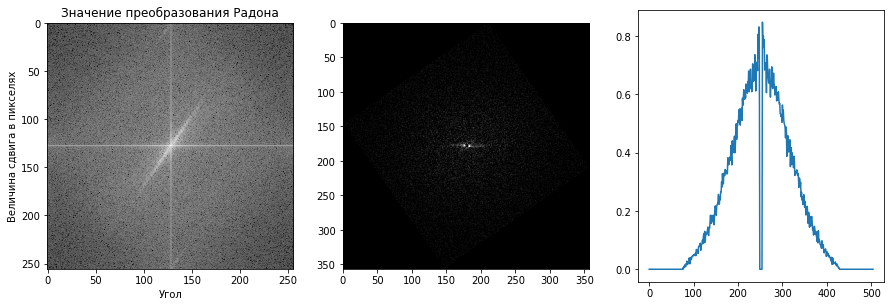

In [35]:
i = -2
image = tmp[i]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.set_title('Значение преобразования Радона')
ax1.set_xlabel('Угол')
ax1.set_ylabel('Величина сдвига в пикселях')


log = c.swap_quarters(np.log(1 + np.abs(np.fft.fft2(Cepstrum.hamming(c.squared_image[-2][-2])))))
ax1.imshow(log, cmap=plt.cm.Greys_r)
plt.imsave('a.png', np.abs(log), cmap=plt.cm.Greys_r)
   
# ax1.imshow(image, cmap=plt.cm.Greys_r)
plt.imsave('square.png', c.squared_image[-2][-2], cmap='gray')
sinogram = image[image.shape[0]//2 - 1]
theta = np.linspace(0., 180., 180, endpoint=False)
if (DEBUG):
    max_values = image.max(axis=0)
    angle = (theta[np.argmax(max_values)] * math.pi/180 - math.pi/2)
    r = radon(image, theta=[angle * 180/math.pi], circle=True)
    rotated_img = ndimage.rotate(c.cepstrum_picture[i], -angle * 180/math.pi)
    rotated_img[rotated_img < 4/255 * rotated_img.max()] = 0
    ax2.imshow(rotated_img, cmap=plt.cm.gray)
#     ax2.imshow(c.cepstrum_picture[i], cmap='gray')

print(math.tan(angle))
print(angle * 180/math.pi)

# ax3.plot(rotated_img[rotated_img.shape[0]//2 - 1])
r = radon(rotated_img, theta=[90], circle=False)
r[r > 0.6 * r.max()] = 0
ax3.plot(r)

In [10]:
# k = make_ker(40, c.angle.mean())
k = rgb2gray(plt.imread("../pict/kers/vert.png"))
q = c.restore_function(img, k)

1  iteration
2  iteration
3  iteration
4  iteration
5  iteration
6  iteration
7  iteration
8  iteration
9  iteration
10  iteration
11  iteration
12  iteration
13  iteration
14  iteration
15  iteration
16  iteration
17  iteration
18  iteration
19  iteration
20  iteration
21  iteration
22  iteration
23  iteration
24  iteration
25  iteration
26  iteration
27  iteration
28  iteration
29  iteration
30  iteration
31  iteration
32  iteration
33  iteration
34  iteration
35  iteration
36  iteration
37  iteration
38  iteration
39  iteration
40  iteration
41  iteration
42  iteration
43  iteration
44  iteration
45  iteration
46  iteration
47  iteration
48  iteration
49  iteration
50  iteration
51  iteration
52  iteration
53  iteration
54  iteration
55  iteration
56  iteration
57  iteration
58  iteration
59  iteration
60  iteration
61  iteration
62  iteration
63  iteration
64  iteration
65  iteration
66  iteration
67  iteration
68  iteration
69  iteration
70  iteration
71  iteration
72  iteration
7

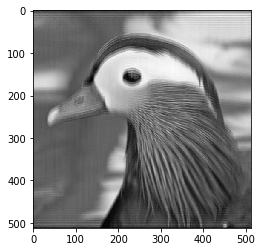

In [11]:
plt.imshow(q, cmap='gray')
plt.imsave('mand.jpg', q, cmap='gray')

In [ ]:
c.blur_len, c.angle.mean()

In [ ]:
%%time
filenames = ['pl_s.jpg']
# filenames = ['pig_big.jpg', 'pl_l.jpg']
# filenames = ['low_pig.jpg', 'mb0_low.jpg']
# filenames = ['pig_lil.jpg']

for filename in filenames:

In [41]:
plt.imsave(save_dir + filename[:-4] + '_restored_img_'+ str(c.batch_size) +'.png', c.minimis._cur_image, cmap='gray')
gc.collect()

102

In [ ]:
plt.imsave('orig.')

In [ ]:
q = make_ker(int(np.mean(c.blur_len)), np.mean(c.angle))

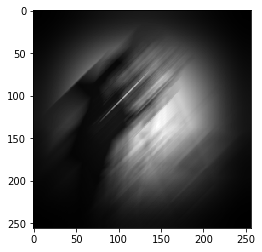

In [43]:
k = rgb2gray(plt.imread("../pict/kers/def.png"))
i = rgb2gray(plt.imread("../pict/default_pics/cameraman.bmp"))
q = ss.convolve2d(i,k, mode='same',boundary='symm')
q = Cepstrum.hamming(q)
plt.imshow(q, cmap='gray')
plt.imsave('cm.png', q, cmap='gray')

In [16]:
plt.imsave('log_' + filename[:-4] + '.png', c.swap_quarters(np.log(1 + np.abs(np.fft.fft2(Cepstrum.hamming(img))))), cmap='gray')

(300, 300) 0.99990004 0.0


array([[0.99205768, 0.99990004, 0.97637296, ..., 0.96068829, 0.97245181,
        0.98421532],
       [0.98421532, 0.98421532, 0.98813653, ..., 0.98813653, 0.98421532,
        0.98421532],
       [0.98029417, 0.99597889, 0.96460944, ..., 0.96460944, 0.96068829,
        0.96460944],
       ...,
       [0.99205768, 0.99205768, 0.95676708, ..., 0.97245181, 0.98029417,
        0.98813653],
       [0.99205768, 0.99205768, 0.96460944, ..., 0.98813653, 0.99205768,
        0.99205768],
       [0.99205768, 0.99597889, 0.97245181, ..., 0.97245181, 0.98029417,
        0.98813653]])

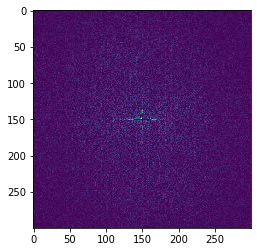

In [40]:
rev = rgb2gray(plt.imread('inv_2.png'))
plt.imshow(rev)
a = inverse_colors(rev)
a

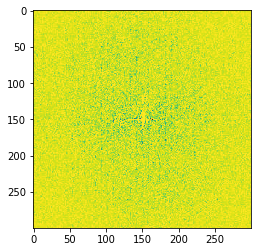

In [38]:
plt.imshow(a)

In [41]:
plt.imsave('i2.png', inverse_colors(rev), cmap='gray')

(300, 300) 0.99990004 0.0


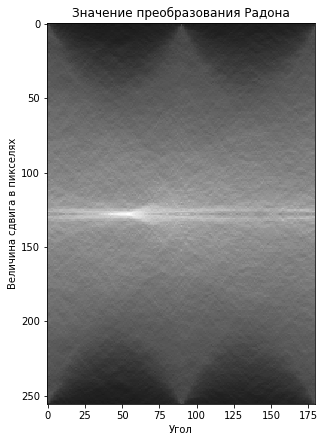

In [20]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 7))
ax1.set_title('Значение преобразования Радона')
ax1.set_xlabel('Угол')
ax1.set_ylabel('Величина сдвига в пикселях')

ax1.imshow(image, cmap=plt.cm.Greys_r)